In [2]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

CPU times: user 186 ms, sys: 15.4 ms, total: 202 ms
Wall time: 201 ms


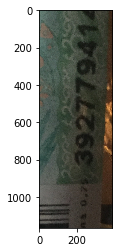

In [3]:
%%time

excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

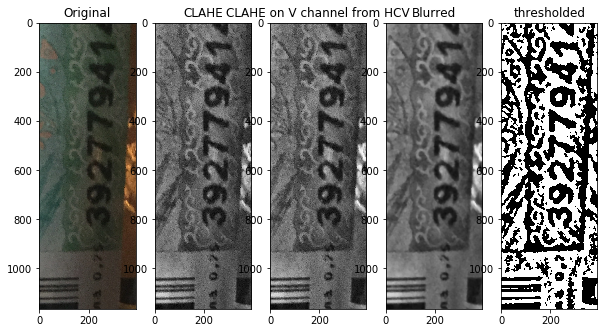

In [29]:
def binarize():
    fig = plt.figure(figsize=(10, 150))

    # resized = imutils.resize(cropped, height=200)
    # gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    # equ = cv2.equalizeHist(gray)
    
    a = fig.add_subplot(1, 5, 1)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Original')

    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    a = fig.add_subplot(1, 5, 2)
    imgplot = plt.imshow(cv2.cvtColor(cl1, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE')
    
    hsv_image = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    
    a = fig.add_subplot(1, 5, 3)
    imgplot = plt.imshow(cv2.cvtColor(v, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE on V channel from HCV')

    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)

    a = fig.add_subplot(1, 5, 4)
    imgplot = plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB))
    a.set_title('Blurred')

    # resized = imutils.resize(blurred, height=500)
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    a = fig.add_subplot(1, 5, 5)
    imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    a.set_title('thresholded')

    plt.show()

    
excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()

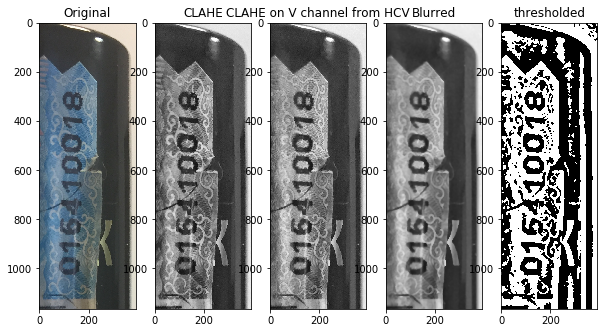

In [30]:
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()

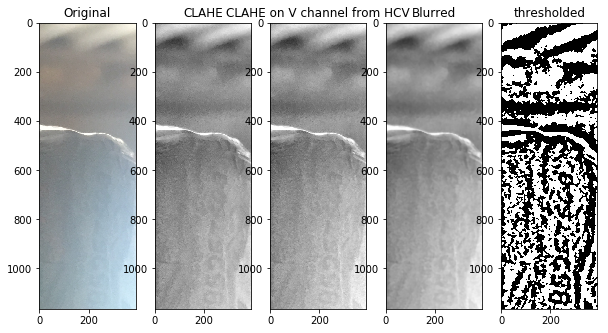

In [16]:
excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 16.2 µs


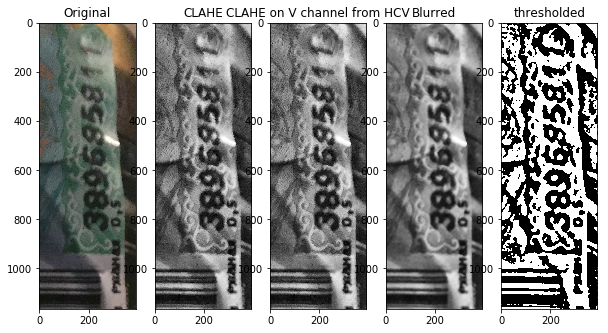

CPU times: user 2.69 s, sys: 493 ms, total: 3.19 s
Wall time: 2.48 s


In [19]:
%%time

excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()

# Try to remove Specular highlight

A specular highlight is the bright spot of light that appears on shiny objects when illuminated (for example, see image at right). Specular highlights are important in 3D computer graphics, as they provide a strong visual cue for the shape of an object and its location with respect to light sources in the scene.

In [60]:
def derive_m(img, rimg):
    ''' Derive m (intensity) based on paper formula '''

    (rw, cl, ch) = img.shape
    for r in range(rw):
        for c in range(cl):
            rimg[r,c] = int(np.sum(img[r,c])/3.0)
            
    return rimg

def derive_saturation(img, rimg):
    ''' Derive staturation value for a pixel based on paper formula '''

    s_img = np.array(rimg)
    (r, c) = s_img.shape
    for ri in range(r):
        for ci in range(c):
            #opencv ==> b,g,r order
            s1 = img[ri,ci][0] + img[ri,ci][2]
            s2 = 2 * img[ri,ci][1] 
            if  s1 >=  s2:
                s_img[ri,ci] = 1.5*(img[ri,ci][2] - rimg[ri,ci])
            else:
                s_img[ri,ci] = 1.5*(rimg[ri,ci] - img[ri,ci][0])

    return s_img

def check_pixel_specularity(mimg, simg):
    ''' Check whether a pixel is part of specular region or not'''

    m_max = np.max(mimg) * 0.5
    s_max = np.max(simg) * 0.33

    (rw, cl) = simg.shape

    spec_mask = np.zeros((rw,cl), dtype=np.uint8)
    for r in range(rw):
        for c in range(cl):
            if mimg[r,c] >= m_max and simg[r,c] <= s_max:
                spec_mask[r,c] = 255
    
    return spec_mask

def enlarge_specularity(spec_mask):
    ''' Use sliding window technique to enlarge specularity
        simply move window over the image if specular pixel detected
        mark center pixel is specular
        win_size = 3x3, step_size = 1
    '''

    win_size, step_size = (3,3), 1
    enlarged_spec = np.array(spec_mask)
    for r in range(0, spec_mask.shape[0], step_size):
        for c in range(0, spec_mask.shape[1], step_size):
            # yield the current window
            win = spec_mask[r:r + win_size[1], c:c + win_size[0]]
            
            if win.shape[0] == win_size[0] and win.shape[1] == win_size[1]:
                if win[1,1] !=0:
                    enlarged_spec[r:r + win_size[1], c:c + win_size[0]] = 255 * np.ones((3,3), dtype=np.uint8)

    return enlarged_spec 

/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in ubyte_scalars
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ubyte_scalars


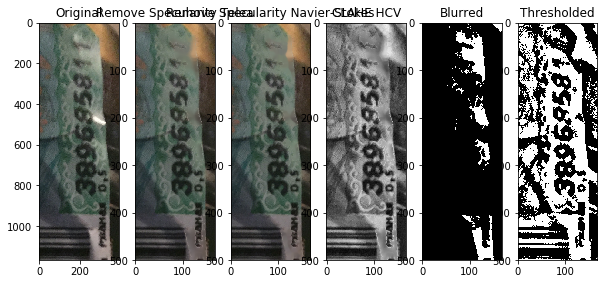

In [62]:
def binarize():
    fig = plt.figure(figsize=(10, 150))

    resized = imutils.resize(cropped, height=500)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    # gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    # equ = cv2.equalizeHist(gray)
    
    a = fig.add_subplot(1, 6, 1)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Original')
   
    r_img = m_img = np.array(gray)

    rimg = derive_m(resized, r_img)
    s_img = derive_saturation(resized, rimg)
    spec_mask = check_pixel_specularity(rimg, s_img)
    # enlarged_spec = enlarge_specularity(spec_mask)
    
    # use opencv's inpaint methods to remove specularity
    radius = 12 
    telea = cv2.inpaint(resized, spec_mask, radius, cv2.INPAINT_TELEA)
    ns = cv2.inpaint(resized, spec_mask, radius, cv2.INPAINT_NS)
    
    a = fig.add_subplot(1, 6, 2)
    imgplot = plt.imshow(cv2.cvtColor(telea, cv2.COLOR_BGR2RGB))
    a.set_title('Remove Specularity Telea')
    
    a = fig.add_subplot(1, 6, 3)
    imgplot = plt.imshow(cv2.cvtColor(ns, cv2.COLOR_BGR2RGB))
    a.set_title('Remove Specularity Navier-Stokes')
    
    # create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    hsv_image = cv2.cvtColor(telea, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    
    a = fig.add_subplot(1, 6, 4)
    imgplot = plt.imshow(cv2.cvtColor(v, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE HCV')

    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)

    a = fig.add_subplot(1, 6, 5)
    imgplot = plt.imshow(cv2.cvtColor(spec_mask, cv2.COLOR_GRAY2RGB))
    a.set_title('Blurred')

    # resized = imutils.resize(blurred, height=500)
    thresholded = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    a = fig.add_subplot(1, 6, 6)
    imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    a.set_title('Thresholded')

    plt.show()
    
excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()

/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in ubyte_scalars
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in ubyte_scalars
/home/levabd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ubyte_scalars


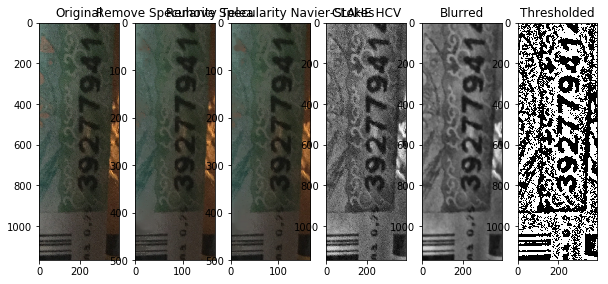

In [75]:
def binarize():
    fig = plt.figure(figsize=(10, 150))

    resized = imutils.resize(cropped, height=500)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    # gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    # equ = cv2.equalizeHist(gray)
    
    a = fig.add_subplot(1, 6, 1)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Original')
   
    r_img = m_img = np.array(gray)

    rimg = derive_m(resized, r_img)
    s_img = derive_saturation(resized, rimg)
    spec_mask = check_pixel_specularity(rimg, s_img)
    # enlarged_spec = enlarge_specularity(spec_mask)
    
    # use opencv's inpaint methods to remove specularity
    radius = 12 
    telea = cv2.inpaint(resized, spec_mask, radius, cv2.INPAINT_TELEA)
    ns = cv2.inpaint(resized, spec_mask, radius, cv2.INPAINT_NS)
    
    a = fig.add_subplot(1, 6, 2)
    imgplot = plt.imshow(cv2.cvtColor(telea, cv2.COLOR_BGR2RGB))
    a.set_title('Remove Specularity Telea')
    
    a = fig.add_subplot(1, 6, 3)
    imgplot = plt.imshow(cv2.cvtColor(ns, cv2.COLOR_BGR2RGB))
    a.set_title('Remove Specularity Navier-Stokes')
    
    # create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
    hsv_image = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    
    a = fig.add_subplot(1, 6, 4)
    imgplot = plt.imshow(cv2.cvtColor(v, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE HCV')

    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)

    a = fig.add_subplot(1, 6, 5)
    imgplot = plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB))
    a.set_title('Blurred')

    # resized = imutils.resize(blurred, height=500)
    thresholded = cv2.adaptiveThreshold(v, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    a = fig.add_subplot(1, 6, 6)
    imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    a.set_title('Thresholded')

    plt.show()
    
# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()

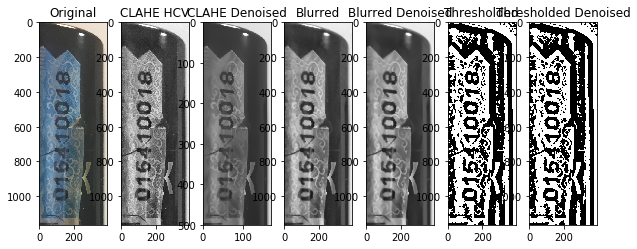

In [3]:
def binarize():
    fig = plt.figure(figsize=(10, 150))

    resized = imutils.resize(cropped, height=500)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    a = fig.add_subplot(1, 7, 1)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Original')
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  
    hsv_image = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    
    a = fig.add_subplot(1, 7, 2)
    imgplot = plt.imshow(cv2.cvtColor(v, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE HCV')

    denoise = cv2.fastNlMeansDenoising(gray,None,7,21)
    a = fig.add_subplot(1, 7, 3)
    imgplot = plt.imshow(cv2.cvtColor(denoise, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE Denoised')
    
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)

    a = fig.add_subplot(1, 7, 4)
    imgplot = plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB))
    a.set_title('Blurred')
    
    a = fig.add_subplot(1, 7, 5)
    imgplot = plt.imshow(cv2.cvtColor(cv2.fastNlMeansDenoising(blurred,None,7,21), cv2.COLOR_GRAY2RGB))
    a.set_title('Blurred Denoised')

    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    a = fig.add_subplot(1, 7, 6)
    imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    a.set_title('Thresholded')
    
    a = fig.add_subplot(1, 7, 7)
    imgplot = plt.imshow(cv2.cvtColor(cv2.fastNlMeansDenoising(thresholded,None,7,21), cv2.COLOR_GRAY2RGB))
    a.set_title('Thresholded Denoised')

    plt.show()
    
# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()

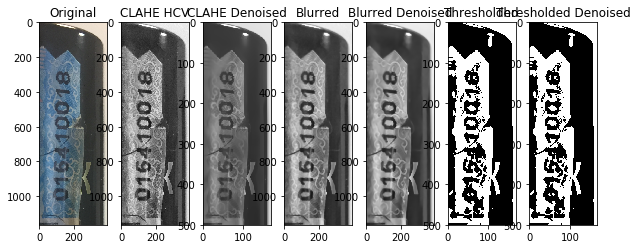

In [4]:
def binarize():
    fig = plt.figure(figsize=(10, 150))

    resized = imutils.resize(cropped, height=500)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    a = fig.add_subplot(1, 7, 1)
    imgplot = plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    a.set_title('Original')
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  
    hsv_image = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
    v = clahe.apply(v)
    
    a = fig.add_subplot(1, 7, 2)
    imgplot = plt.imshow(cv2.cvtColor(v, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE HCV')

    denoise = cv2.fastNlMeansDenoising(gray,None,7,21)
    a = fig.add_subplot(1, 7, 3)
    imgplot = plt.imshow(cv2.cvtColor(denoise, cv2.COLOR_GRAY2RGB))
    a.set_title('CLAHE Denoised')
    
    blurred = cv2.bilateralFilter(v, 9, 75, 75)
    blurred = cv2.medianBlur(blurred, 5)

    a = fig.add_subplot(1, 7, 4)
    imgplot = plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_GRAY2RGB))
    a.set_title('Blurred')
    
    a = fig.add_subplot(1, 7, 5)
    imgplot = plt.imshow(cv2.cvtColor(cv2.fastNlMeansDenoising(blurred,None,7,21), cv2.COLOR_GRAY2RGB))
    a.set_title('Blurred Denoised')

    thresholded = cv2.adaptiveThreshold(denoise, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    a = fig.add_subplot(1, 7, 6)
    imgplot = plt.imshow(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB))
    a.set_title('Thresholded')
    
    a = fig.add_subplot(1, 7, 7)
    imgplot = plt.imshow(cv2.cvtColor(cv2.fastNlMeansDenoising(thresholded,None,7,21), cv2.COLOR_GRAY2RGB))
    a.set_title('Thresholded Denoised')

    plt.show()
    
# excise_src = cv2.imread("data/premasked/IMG_0676.JPG")
excise_src = cv2.imread("data/premasked/IMG_0549.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0562.JPG")
# excise_src = cv2.imread("data/premasked/IMG_0595.JPG")
cropped = excise_src[78:78+1166, 1276:1276+392]
binarize()